In [67]:
from actsnfink import *
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from actsnclass.metrics import get_snpcc_metric
import matplotlib.pylab as plt
import pickle
from shutil import copy

In [19]:
if True:
    #########     User choices: general    #########################
    
    create_matrix = False            # create raw data file by combining all TNS + a few simbad files
    n_files_simbad = 5              # number of simbad files randomly chosen to compose the raw data
    initial_state_from_file = False  # read initial state from a fixed file
    
    
    fname_features_matrix = '/media/emille/git/Fink/supernova_al/referee/data/features.csv'               # output features file
    fname_raw_output = '/media/emille/git/Fink/supernova_al/referee/data/raw.csv.gz'                      # output raw data file
    dirname_input = '../../../data/AL_data/'                     # input directory with labelled alerts
    dirname_output = '../data/20230907/'                         # root products output directory
    append_name = ''                                             # append to all metric, prob and queries names
    
    nloops = 1                          # number of learning loops
    strategy = 'UncSampling'            # query strategy
    initial_training = 10               # total number of objs in initial training
    frac_Ia_tot = 0.5                   # fraction of Ia in initial training 
    n_realizations = 1                  # total number of realizations
    n_realizations_ini = 0              # start from this realization number
    new_raw_file = False                 # save raw data in one file
    input_raw_file = fname_raw_output   # name of raw data file
    n = 15000                           # number of random simbad objects per file 
                                        # to be used as part of the raw data
    
    drop_zeros = True                   # ignore objects with observations in only 1 filter
    screen = True                       # print debug comments to screen
    

In [12]:
# create directory structure

features_names = ['a_g', 'b_g', 'c_g', 'snratio_g', 'mse_g', 'nrise_g', 
                          'a_r', 'b_r', 'c_r', 'snratio_r', 'mse_r', 'nrise_r']
    
for name in [dirname_output + '/', 
             dirname_output + '/' + strategy + '/', 
             dirname_output + '/' + strategy + '/models/', 
             dirname_output + '/' + strategy + '/class_prob/',
             dirname_output + '/' + strategy + '/metrics/', 
             dirname_output + '/' + strategy + '/queries/',
             dirname_output + '/' + strategy + '/training_samples/', 
             dirname_output + '/' + strategy + '/test_samples/']:
    if not os.path.isdir(name):
        os.makedirs(name)  

In [15]:
# create initial data matrix
if create_matrix:
    matrix_clean = build_matrix(fname_output=fname_features_matrix, dirname_input=dirname_input, dirname_output=dirname_output + 'data/',
                                fname_raw_output=fname_raw_output, new_raw_file=new_raw_file,
                                input_raw_file=input_raw_file,n=n,
                               n_files_simbad=n_files_simbad, drop_zeros=drop_zeros, screen=screen)
    print(np.unique(matrix_clean['type'].values))
        
else:
    matrix_clean = pd.read_csv(fname_features_matrix, comment='#')   

In [20]:
if True:
    if initial_state_from_file:
        fname_ini_train = dirname_output + '/UncSampling/training_samples/initialtrain_v' + str(initial_state_version) + '.csv'              
        fname_ini_test = dirname_output + '/UncSampling/test_samples/initial_test_v' + str(initial_state_version) + '.csv'
    
        output_metrics_file = dirname_output + '/' + strategy + '/metrics/metrics_' + strategy + '_v' + str(initial_state_version) + append_name + '.dat'
        output_queried_file = dirname_output + '/' + strategy + '/queries/queried_' + strategy + '_v'+ str(initial_state_version) + append_name + '.dat'
        output_prob_root = dirname_output + '/' + strategy + '/class_prob/v' + str(initial_state_version) + '/class_prob_' + strategy + append_name
    
        name = dirname_output + '/' + strategy + '/class_prob/v' + str(initial_state_version) + '/'
        if not os.path.isdir(name):
            os.makedirs(name)
        data = read_initial_samples(fname_ini_train, fname_ini_test)
        
        # perform learnin loop
        learn_loop(data, nloops=nloops, strategy=strategy, 
                   output_metrics_file=output_metrics_file, 
                   output_queried_file=output_queried_file,
                   classifier='RandomForest', seed=None,
                   batch=1, screen=True, output_prob_root=output_prob_root)
        
    else:
        for v in range(n_realizations_ini, n_realizations):
            output_metrics_file = dirname_output + '/' + strategy + '/metrics/metrics_' + strategy + '_v' + str(v) + append_name + '.dat'
            output_queried_file = dirname_output + '/' + strategy + '/queries/queried_' + strategy + '_v'+ str(v) + append_name + '.dat'
            output_prob_root = dirname_output + '/' + strategy + '/class_prob/v' + str(v) + '/class_prob_' + strategy + append_name
    
            name = dirname_output + '/' + strategy + '/class_prob/v' + str(v) + '/'
            if not os.path.isdir(name):
                os.makedirs(name)
            #build samples        
            data = build_samples(matrix_clean, initial_training=initial_training, screen=True)
        
            # save initial data        
            train = pd.DataFrame(data.train_features, columns=features_names)
            train['objectId'] = data.train_metadata['id'].values
            train['type'] = data.train_metadata['type'].values
            train.to_csv(dirname_output + '/' + strategy + '/training_samples/initialtrain_v' + str(v) + '.csv', index=False)
        
            test = pd.DataFrame(data.test_features, columns=features_names)
            test['objectId'] = data.test_metadata['id'].values
            test['type'] = data.test_metadata['type'].values
            test.to_csv(dirname_output + '/' + strategy + '/test_samples/initial_test_v' + str(v) + '.csv', index=False)        
    
            # perform learnin loop
            learn_loop(data, nloops=nloops, strategy=strategy, 
                   output_metrics_file=output_metrics_file, 
                   output_queried_file=output_queried_file,
                   classifier='RandomForest', seed=None,
                   batch=1, screen=True, output_prob_root=output_prob_root)
    


 temp_labels =  ['Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'QSO' 'EB*' 'EB*' 'Star' 'RRLyr'] 

Training set size:  10
Test set size:  23765
  from which queryable:  23765
Processing...  0

 Metrics:  [0.7488743951188723, 0.7172413793103448, 0.1717459840864735, 0.04637039490992]

 Inside make_query: 
       ... classprob:  23765
       ... queryable_ids:  23765
       ... test_ids:  23765

 Inside UncSampling: 
       query_ids:  [1296277080715015003] 

   number of test_ids:  23765
   number of queryable_ids:  23765 

   *** Displacement caused by constraints on query****
   0 ->  0
    [0.5 0.5] -- >  [0.5 0.5] 

indx:  [19645]


In [45]:
# Save new model
# read train, test and query data
indx = [0]
date = '20230907'

dirname = '/media/emille/git/Fink/supernova_al/repository/al_real_time/data/' + date + '/'

fname = dirname + '/UncSampling/training_samples/initialtrain_v' + str(indx[0]) + '.csv'
data_train = pd.read_csv(fname, index_col=False)

fname = dirname + '/UncSampling/test_samples/initial_test_v' + str(indx[0]) + '.csv'
data_test = pd.read_csv(fname, index_col=False)

fname = dirname + '/UncSampling/queries/queried_UncSampling_v' + str(indx[0]) + '.dat'
data_query = pd.read_csv(fname, skiprows=1, names=['day','id','type'] + list(data_train.keys())[:-2],index_col=False)

In [46]:
# transfer data from test to train
flag = np.array([item in data_query['id'].values for item in data_test['objectId'].values])

data_train2 = pd.concat([data_train, data_test[flag]], ignore_index=True)
data_test2 = data_test[~flag]

In [49]:
clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(data_train2[list(data_train2.keys())[:-2]], data_train2['type'].values == 'Ia')

RandomForestClassifier(n_estimators=1000, random_state=42)

In [50]:
clf.score(data_test2[list(data_test2.keys())[:-2]], data_test2['type'].values == 'Ia')

0.8193065140548729

In [57]:
pred = clf.predict(data_test2[list(data_test2.keys())[:-2]])
pred_prob = clf.predict_proba(data_test2[list(data_test2.keys())[:-2]])

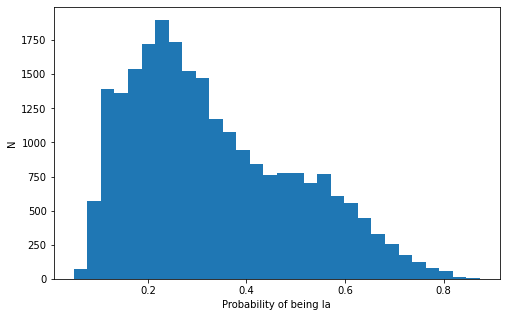

In [61]:
plt.figure(figsize=(8,5))
plt.hist(pred_prob[:,1], bins=30)
plt.ylabel('N')
plt.xlabel('Probability of being Ia')
plt.show()

In [62]:
sum(pred_prob[:,1] == 0.5)

24

In [54]:
get_snpcc_metric(pred, data_test2['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [0.8193065140548729,
  0.5855799373040752,
  0.20451061966279835,
  0.04622087901986024])

In [66]:
pickle.dump(clf, open(dirname + 'UncSampling/models/model_' + date + '.pkl', 
                      'wb'))

In [68]:
# copy model to fink-science
copy(dirname + 'UncSampling/models/model_' + date + '.pkl', 
     '/media/emille/git/Fink/fink-science/fink_science/data/models/for_al_loop/model_' + date + '.pkl')

'/media/emille/git/Fink/fink-science/fink_science/data/models/for_al_loop/model_20230907.pkl'